<a href="https://colab.research.google.com/github/dvircohen0/projects/blob/main/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
gender_submission_url= 'https://raw.githubusercontent.com/minsuk-heo/kaggle-titanic/master/input/gender_submission.csv'
train_url= 'https://raw.githubusercontent.com/minsuk-heo/kaggle-titanic/master/input/train.csv'
test_url= 'https://raw.githubusercontent.com/minsuk-heo/kaggle-titanic/master/input/test.csv'

In [3]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer,  SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score, f1_score,precision_score, recall_score,roc_auc_score 
from sklearn.linear_model import Perceptron,SGDClassifier,LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.ensemble import  VotingClassifier, RandomForestClassifier

from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout

import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
test=pd.read_csv(test_url)
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [8]:
train=pd.read_csv(train_url)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

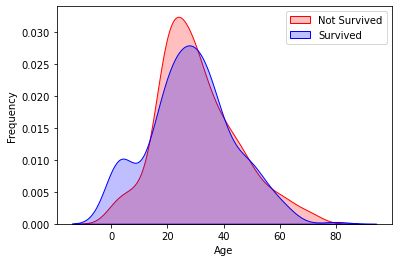

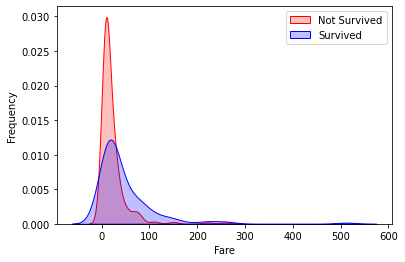

<Figure size 432x288 with 0 Axes>

In [10]:
columns = ['Age', 'Fare']

for feature in columns:
    g = sns.kdeplot(train[feature][(train["Survived"] == 0) & (train[feature].notnull())], color="Red", shade = True)
    g = sns.kdeplot(train[feature][(train["Survived"] == 1) & (train[feature].notnull())], ax =g, color="Blue", shade= True)
    g.set_xlabel(feature)
    g.set_ylabel("Frequency")
    g = g.legend(["Not Survived","Survived"])
    plt.figure()

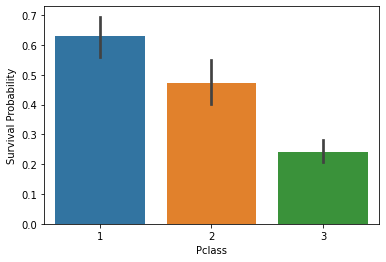

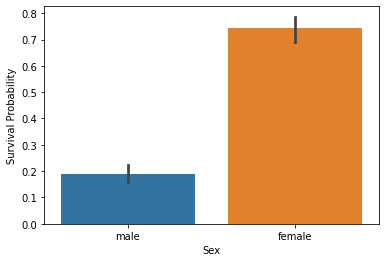

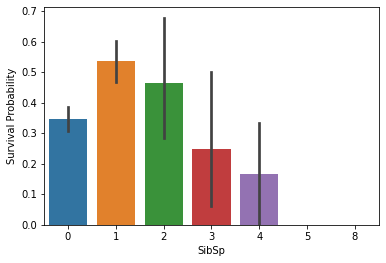

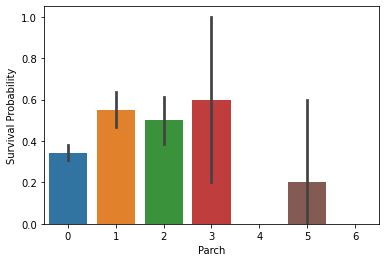

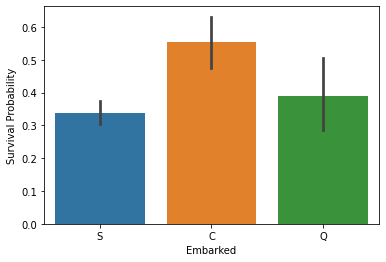

<Figure size 432x288 with 0 Axes>

In [11]:
categorical = ['Pclass','Sex','SibSp','Parch', 'Embarked']
       

for feature in categorical:
    g = sns.barplot(x=feature,y="Survived",data=train)
    g = g.set_ylabel("Survival Probability")
    plt.figure()

In [12]:
y = train['Survived']
X=train.drop('Survived',axis='columns')

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.33, random_state=42)

In [13]:
# use the first letter on the cabin name as a cabin nuber feature
def cabine_edit(X):
    X=X.fillna('U')
    X=X.applymap(lambda x: x[0])
    X=X.applymap(lambda x: x.replace('T', 'U'))
    return X

def name_edit(X):
    common = ["Mr.","Miss.","Mrs.","Master.","Dr."]
    X=X.applymap(lambda x: x[1])
    X=X.applymap(lambda x: x if x in common else 'Rare')
    return X

# pipe for numeric features, fill Nan and scale
numer_pipe=make_pipeline(IterativeImputer(max_iter=10,random_state=0),
                      StandardScaler())

# wrap the cabin_edin func to fit into pipline
cabine_pipe=make_pipeline(FunctionTransformer(cabine_edit),
                          OrdinalEncoder())

# fill missing values and  one hot encode
Embarked_pipe=make_pipeline(SimpleImputer(missing_values=np.nan,
                            strategy='most_frequent')
                            ,OneHotEncoder())


# fill missing values and  one hot encode
Name_pipe=make_pipeline(FunctionTransformer(name_edit)
                            ,OneHotEncoder())


column_trans = make_column_transformer(
    (numer_pipe, ['Age','Fare']),
    (OneHotEncoder(), ['Sex']),
    (Embarked_pipe, ['Embarked']),
    (cabine_pipe, ['Cabin']),
    (Name_pipe,['Name']),
    ('drop',['PassengerId','Ticket']),
    remainder='passthrough')

**Trying different models**

In [14]:
sgd = SGDClassifier(max_iter=5, tol=None)
random_forest = RandomForestClassifier(n_estimators=100)
logreg = LogisticRegression()
knn = KNeighborsClassifier(n_neighbors = 5)
gaussian = GaussianNB()
perceptron = Perceptron()
linear_svc = LinearSVC(dual=False)
decision_tree = DecisionTreeClassifier()

models= [sgd,random_forest,logreg,knn,gaussian,perceptron,
        linear_svc,decision_tree]


for model in models:
    print(model)
    pipe=make_pipeline(column_trans,model)
    pipe.fit(X_train,y_train)
    y_pred = pipe.predict(X_test)
    
    print("cross validation: {:.2f}".format(cross_val_score(pipe,X_train,y_train,cv=5,scoring='accuracy').mean()))
    print("Acuraccy: {:.2f}".format(accuracy_score(y_test, y_pred)))
    print("F1: {:.2f}".format(f1_score(y_test, y_pred)))
    print("Precision: {:.2f}".format(precision_score(y_test, y_pred)))
    print("Recall: {:.2f}".format(recall_score(y_test, y_pred)))
    print("ROC-AUC-Score: {:.2f}".format(roc_auc_score(y_test, y_pred)))
    print("")

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=None,
              validation_fraction=0.1, verbose=0, warm_start=False)
cross validation: 0.72
Acuraccy: 0.81
F1: 0.77
Precision: 0.76
Recall: 0.78
ROC-AUC-Score: 0.81

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_

**Trying ensemble model**

In [15]:
eclf1 = VotingClassifier(estimators=[
 ('lr', linear_svc),
 ('random_forest', random_forest),
 ('logreg', logreg)],
  voting='hard')

pipe=make_pipeline(column_trans,eclf1)
pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_test)

print("cross validation: {:.2f}".format(cross_val_score(pipe,X_train,y_train,cv=5,scoring='accuracy').mean()))
print("Acuraccy: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("F1: {:.2f}".format(f1_score(y_test, y_pred)))
print("Precision: {:.2f}".format(precision_score(y_test, y_pred)))
print("Recall: {:.2f}".format(recall_score(y_test, y_pred)))
print("ROC-AUC-Score: {:.2f}".format(roc_auc_score(y_test, y_pred)))
print("")

cross validation: 0.80
Acuraccy: 0.82
F1: 0.77
Precision: 0.81
Recall: 0.73
ROC-AUC-Score: 0.81



**Perform Grid Search on best Model**

In [16]:
params = {'C' : np.arange(0.01,100,10)}
clf =  GridSearchCV(linear_svc, params)
pipe=make_pipeline(column_trans,clf)
pipe.fit(X_train,y_train)
y_pred = pipe.predict(X_test)
print("cross validation: {:.2f}".format(cross_val_score(pipe,X_train,y_train,cv=5,scoring='accuracy').mean()))
print("Acuraccy: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("F1: {:.2f}".format(f1_score(y_test, y_pred)))
print("Precision: {:.2f}".format(precision_score(y_test, y_pred)))
print("Recall: {:.2f}".format(recall_score(y_test, y_pred)))
print("ROC-AUC-Score: {:.2f}".format(roc_auc_score(y_test, y_pred)))
print("")

cross validation: 0.79
Acuraccy: 0.82
F1: 0.76
Precision: 0.81
Recall: 0.72
ROC-AUC-Score: 0.80



**Trying neural network**

In [ ]:
def build_classifier():
    classifier = Sequential()
    classifier.add(Dense(units=10,kernel_initializer='uniform',activation='relu',input_dim=12))
    classifier.add(Dropout(rate = 0.2))
    classifier.add(Dense(units=128,kernel_initializer='uniform',activation='relu'))
    classifier.add(Dropout(rate = 0.2))
    classifier.add(Dense(units=1,kernel_initializer='uniform',activation='sigmoid'))
    classifier.compile(optimizer="Adam",loss='binary_crossentropy',metrics=['accuracy'])
    return classifier


classifier = KerasClassifier(build_fn = build_classifier)
param_grid = dict(epochs=[10, 20, 50], batch_size=[16, 25, 32])
grid = GridSearchCV(estimator=classifier, param_grid=param_grid, scoring='accuracy')

pipe=make_pipeline(column_trans,grid)
pipe.fit(X_train,y_train)



In [18]:
y_pred=pipe.predict(X_test)
print("Acuraccy: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("F1: {:.2f}".format(f1_score(y_test, y_pred)))
print("Precision: {:.2f}".format(precision_score(y_test, y_pred)))
print("Recall: {:.2f}".format(recall_score(y_test, y_pred)))
print("ROC-AUC-Score: {:.2f}".format(roc_auc_score(y_test, y_pred)))
print("")

Acuraccy: 0.82
F1: 0.77
Precision: 0.83
Recall: 0.71
ROC-AUC-Score: 0.81



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
